# Classical Simulation

Many quantum information subroutines are reversible classical operations. The catch is that they are operated on superpositions of classical bitstrings. However, we can unit test these operations by checking against specific bitstrings through the `call_classically` bloqs protocol.

In [1]:
from typing import *

import numpy as np
from attrs import frozen
from numpy.typing import NDArray

from qualtran import Bloq, BloqBuilder, Register, Signature, Side
from qualtran.drawing import show_bloq

## CNOT

The simplest classical gate is the controlled not. This flips the target bit if `ctrl` is set. We can implement the `on_classical_vals` method to encode this behavior.

In [2]:
@frozen
class CNOTExample(Bloq):
    @property
    def signature(self) -> 'Signature':
        return Signature.build(ctrl=1, target=1)

    def on_classical_vals(
        self, ctrl: NDArray[np.uint8], target: NDArray[np.uint8]
    ) -> Dict[str, NDArray[np.uint8]]:
        target_out = (ctrl + target) % 2
        return {'ctrl': ctrl, 'target': target_out}

We can call the Bloq on classical inputs by using `Bloq.call_classically()`. 

In [3]:
CNOTExample().call_classically(ctrl=1, target=0)

(1, 1)

In [4]:
import itertools
for c, t in itertools.product([0,1], repeat=2):
    out_c, out_t = CNOTExample().call_classically(ctrl=c, target=t)
    print(f'{c}{t} -> {out_c}{out_t}')

00 -> 00
01 -> 01
10 -> 11
11 -> 10


### Drawing

We can draw the flow of classical values as well using `ClassicalSimGraphDrawer`

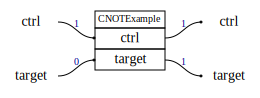

In [5]:
from qualtran.drawing import ClassicalSimGraphDrawer

drawer = ClassicalSimGraphDrawer(CNOTExample(), vals=dict(ctrl=1, target=0))
drawer.get_svg()

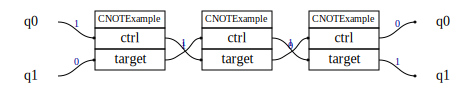

In [6]:
# Build a SWAP circuit
bb = BloqBuilder()
q0 = bb.add_register('q0', 1)
q1 = bb.add_register('q1', 1)
q0, q1 = bb.add(CNOTExample(), ctrl=q0, target=q1)
q1, q0 = bb.add(CNOTExample(), ctrl=q1, target=q0)
q0, q1 = bb.add(CNOTExample(), ctrl=q0, target=q1)
cbloq = bb.finalize(q0=q0, q1=q1)

drawer = ClassicalSimGraphDrawer(cbloq, vals=dict(q0=1, q1=0))
drawer.get_svg()

## Quantum Data Types

To convert back and forth between classical values and bitstrings, we use the `QDType.to_bits` and `QDType.from_bits` functions.


### QFxp classical values

Currently, QFxp classical values are represented as fixed-width integers.
See the class docstring for QFxp for precise details.
To convert from true floating point values to this representation and vice-versa,
users can use `QFxp.to_fixed_width_int` and `QFxp.float_from_fixed_width_int` respectively.

In [7]:
from qualtran import QFxp

@frozen
class DoubleFxp(Bloq):
    """Bloq with a QFxp of 4 bits (0 int, 4 frac).
    
    This bloq doubles the input value inplace, discarding any overflow
    """
    num_frac: int = 4
    
    @property
    def signature(self) -> Signature:
        return Signature.build_from_dtypes(x=QFxp(self.num_frac, self.num_frac))
    
    def on_classical_vals(self, x) -> dict[str, 'ClassicalValT']:
        """Double the input value, discarding overflow"""
        return {'x': (x * 2) % (2**self.num_frac)}


bloq_with_qfxp = DoubleFxp()
x_float = 0.25
x_as_int = QFxp(4, 4).to_fixed_width_int(x_float)
(x_out_as_int,) = bloq_with_qfxp.call_classically(x=x_as_int)
x_out_float = QFxp(4, 4).float_from_fixed_width_int(x_out_as_int)
assert x_out_float == 0.5